# Pathway Analysis
#### Chelsea Alvarado (https://github.com/alvaradocx)
* You must change column names, values, etc to match your pathway you're looking at

### Table of Contents

* [1. Setup](#Setup)
    * [1.1 .env Setup](#.env)
* [2. One Hop Pathway](#OneHop)
    * [2.1 Data Read in/Query](#DataRead11)
    * [2.2 Create multi index dataframe](#multiindex)
    * [2.3 Export Multi-Index df](#export1)
    * [2.4 Creating Subsets of Main DataFrame](#subset)
        * [2.4.1 Breaking Up Main DF into Smaller Subsets for all Relationships](#mainSubsets)
        * [2.4.2 Multi-Index for Upstream c to a](#ctoa)
        * [2.4.3 Export out](#export2)
    * [2.5  Data Operations](#operations)
        * [2.5.1 Calculate Downstream Neuron Counts](#dstrCount)
            * [2.5.1.1 Export out](#export3)
        * [2.5.2 Calculate Upstream Neuron Counts](#upstrCount) 
            * [2.5.2.1 Export out](#export4)
        * [2.5.3 Interneuron Count](#interCount)
            * [2.5.3.1 Method 1](#m1)
            * [2.5.3.2 Method 2](#m2)
        * [2.5.4 Calculate Combined Weights](#weights)
* [3. Direct Pathway](#direct)
    * [3.1 Data Readin/Query](#read2)
    * [3.2 Visualization](#visual)
        * [3.2.1 Heatmap by Body ID](#heat1)
        * [3.2.2 Query by Type](#heat2)
            * [3.2.2.1 Modify DataFrame for Heatmap](#mod)
    

## 1. Setup <a name="Setup"></a>

In [1]:
import pandas as pd
from neuprint import Client, fetch_custom # used when running queries on neuprint

### 1.1 .env file for authorization token (optional but recommended) <a name=".env"></a>

Please reference this [Jupyter Notebook](https://github.com/alvaradocx/CAT-work/blob/main/General%20Scripts/environment_setup.ipynb) for directions on how to set and what an .env file is

In [ ]:
# libraries for .env
import dotenv
import os

# load in .env
dotenv.load_dotenv()

# declare token var
token = os.getenv('authToken')

## 2. One Hop Pathway <a name="OneHop"></a>

### Section 2.1 Data read in/Query <a name="DataRead1"></a>

#### Read in from existing CSV

In [2]:
# read in data frame
# main df for full file
one_hop = pd.read_csv('TrueCX1Hop_6-22.csv')
one_hop
one_hop.columns = ['Non-oAL_ID','Non-oAL_Type','Weight1','Interneuron_ID','Interneuron_Type','Weight2','CX_ID','CX_Type']
one_hop = one_hop.drop(['Non-oAL_Type','Interneuron_Type','CX_Type'], axis=1)

# df with interneuron duplicates removed for a to b
atob_unique = one_hop[['Non-oAL_ID','Weight1','Interneuron_ID']].drop_duplicates()

#### Run query (only run if you don't have CSV file)

In [ ]:
# uncomment if you are not using .env method
# token = ""

c = Client('neuprint-test.janelia.org', dataset='hemibrain', token = token, verify=True)

starting_body_list = []

def createQueryDataframe():
    #basic one hop query from a starter list to a CX neuron. 
    query = fetch_custom("""\
    WITH """ + str(starting_body_list) + """ AS TARGETS
    MATCH (a:Neuron)-[w:ConnectsTo]->(b:Neuron)-[ww:ConnectsTo]->(c:Neuron)
    WHERE a.bodyId IN TARGETS AND c.`CX` AND w.weight > 9 AND ww.weight > 9
    RETURN a.bodyId, a.type, w.weight, b.bodyId, b.type, ww.weight, c.bodyId, c.type""")
    return query

one_hop = createQueryDataframe()

In [ ]:
# format df
one_hop.columns = ['Non-oAL_ID','Non-oAL_Type','Weight1','Interneuron_ID','Interneuron_Type','Weight2','CX_ID','CX_Type']
one_hop = one_hop.drop(['Non-oAL_Type','Interneuron_Type','CX_Type'], axis=1)

# df with interneuron duplicates removed for a to b
atob_unique = one_hop[['Non-oAL_ID','Weight1','Interneuron_ID']].drop_duplicates()

### Section 2.2 Create multi index dataframe <a name="multiindex"></a>

In [3]:
# create multiindex of main df
onehop_multi = one_hop.set_index(['Non-oAL_ID','Interneuron_ID'])
onehop_multi

Weight1  Weight2       CX_ID
Non-oAL_ID Interneuron_ID                              
603785283  758636869            17       12   789308735
           480258208            10       19  1050935614
           480258208            10       16   953414780
           480258208            10       11  5813087837
           358264919            15       12   922069357
...                            ...      ...         ...
1755556097 702364805            10       34  5813062858
5813056072 702364805            23       18   513784136
           702364805            23      132  5813047763
           702364805            23       34  5813062858
           1671608112           31       12   732034061

[236 rows x 3 columns]

#### Sub-Section 2.2.1 Export Multi-index DataFrame (optional) <a name="export1"></a>

In [8]:
onehop_multi.to_csv('FILE NAME.csv')

### Section 2.4 Creating Subsets of Main DataFrame <a name="subset"></a>

#### Sub-Section 2.4.1 Break up main dataframe into smaller dataframes <a name="mainSubsets"></a>
* a->b->c
* creates data frames for each chunk of one hop relationship (a to , b to c)
* creates dataframes for other possible relationships ( c to a, b to a, c to b)

In [11]:
# create smaller data frames
# df for sensory to interneuron(a to b)
atob = atob_unique[['Non-oAL_ID','Weight1','Interneuron_ID']]
# multi index
atob_multi = atob.set_index(['Non-oAL_ID','Interneuron_ID'])

# df for interneuron to CX (b to c)
btoc = one_hop[['Interneuron_ID','Weight2','CX_ID']].drop_duplicates()
# multi index 
btoc_multi = btoc.set_index(['Interneuron_ID','CX_ID'])

# df for interneurons (b to a)
inter = one_hop[["Interneuron_ID","Weight1","Non-oAL_ID"]].drop_duplicates()
# multindex
inter_multi = inter.set_index(['Interneuron_ID', 'Non-oAL_ID']).sort_values('Interneuron_ID')

# df for Cx to inter(c to b)
ctob = one_hop[['Interneuron_ID','Weight2','CX_ID']].drop_duplicates()
# multi index 
ctob_multi =ctob.set_index(['CX_ID','Interneuron_ID'])

# for cx to oal (c to a)
ctoa =one_hop[['CX_ID', 'Weight2', 'Non-oAL_ID']].drop_duplicates()
# multi index
ctoa_multi = ctoa.set_index(['CX_ID','Non-oAL_ID']).sort_values('CX_ID')


#### Sub-Section 2.4.2 Multi-index for upstream of c to a <a name="ctoa"></a>
i.e. how many starting bodies does the final neuron receive information from

In [10]:
# multiindex cx to non oal
ctoa = one_hop[['CX_ID', 'Weight2', 'Non-oAL_ID']]

reverse = ctoa.set_index(['CX_ID','Non-oAL_ID']).sort_values('CX_ID')
reverse

,,Weight2
CX_ID,Non-oAL_ID,
294450495,5813063239,18
294800293,1858901026,10
295116205,5813063239,17
295141570,5813063239,19
295819960,5813063239,24
...,...,...
5813078563,1944502935,33
5813081818,1858901026,11
5813087837,1975878958,11


#### Sub-Section 2.4.3 Export out DataFrame  <a name="export2"></a>

In [ ]:
reverse.to_csv('FILE NAME.csv')

### Section 2.5 Data Operations <a name="operations"></a>
####  Sub-Section 2.5.1 Calculate downstream neuron counts <a name="dstrCount"></a>

In [12]:
# calculate downstream neuron counts
# sensory to inter count ie how many interneurons the sensory body synapses onto
downstream_sense = atob.groupby(['Non-oAL_ID','Interneuron_ID']).count()\
       .reset_index().groupby('Non-oAL_ID')['Interneuron_ID'].nunique()

# inter to CX count ie how many cx neurons the inter body synapses onto
downstream_inter = btoc.groupby(['Interneuron_ID', 'CX_ID']).count()\
       .reset_index().groupby('Interneuron_ID')['CX_ID'].nunique()

##### 2.5.1.1 Export out <a name = 'export3'></a>
Make sure to change file name or you'll overwrite the existing file

In [ ]:
# a to b downstream count
downstream_sense.to_csv('FILE NAME.csv')

# b to c downstream count
downstream_inter.to_csv('FILE NAME.csv')

#### Sub-Section 2.5.2 Calculate upstream neuron counts <a name = 'upstrCount'></a>

In [13]:
# calculate upstream inter to sensory b to a; count how many upstream (a) neurons b receives information from
upstream_inter = inter_multi.groupby(['Interneuron_ID', 'Non-oAL_ID']).count()\
        .reset_index().groupby('Interneuron_ID')['Non-oAL_ID'].nunique()

# calculate upstream cx to inter c to b; count how many upstream (b) neurons c receives information from
upstream_cx = ctob_multi.groupby(['CX_ID', 'Interneuron_ID']).count()\
        .reset_index().groupby('CX_ID')['Interneuron_ID'].nunique()

# calculate upstream cx to inter c to a; count how many upstream (a) neurons c receives information from
upstream_sense = ctoa_multi.groupby(['CX_ID', 'Non-oAL_ID']).count()\
        .reset_index().groupby('CX_ID')['Non-oAL_ID'].nunique()

##### 2.5.2.1 Export out <a name = 'export4'> </a>
Make sure to change file name or you'll overwrite the existing file

In [ ]:
# b to a count
upstream_inter.to_csv('FILE NAME.csv')

# c to b count
upstream_cx.to_csv('FILE NAME.csv')

# c to a count
upstream_sense.to_csv('FILE NAME.csv')

#### Sub-Section 2.5.3 Interneuron count <a name = 'interCount'></a>
* Keeping track of how many times an interneuron shows up in the one hop pathway relationship
* two different methods you can use

##### 2.5.3.1 Method 1 <a name = 'm1'></a>

In [ ]:
# how many times an interneuron body is involved in a one hop pathway (a->b->c) not unique
inter = dict()
for i in range(0, len(one_hop['Interneuron_ID'])):
    
    if one_hop['Interneuron_ID'][i] not in inter: 
        
        inter[one_hop['Interneuron_ID'][i]] = 1
          
    else:
        inter[one_hop['Interneuron_ID'][i]] += 1

inter

##### 2.5.3.2 Method 2 <a name = 'm2'></a>

In [ ]:
# how many times an interneuron body is involved in a one hop pathway (a->b->c) not unique
counts = dict()
for i in one_hop['Interneuron_ID']:
    counts[i] = counts.get(i, 0) + 1
    
counts

#### Sub-Section 2.5.4 Calculate the combined weights <a name = 'weights'></a>

In [15]:
# sum(combined) downstream weights

# from non-oAL to inter; 
sum_atob = atob_multi.sum(level = 'Non-oAL_ID').sort_values(by = 'Non-oAL_ID')

# inter to nonoOAL
sum_btoa = inter_multi.sum(level = "Interneuron_ID").sort_values(by = 'Interneuron_ID')

# from inter to cx
sum_btoc = btoc_multi.sum(level = "Interneuron_ID").sort_values(by = 'Interneuron_ID')

# cx to inter
sum_ctob = ctob_multi.sum(level = "CX_ID").sort_values(by = 'CX_ID')

# cx to non-oal
sum_ctoa = ctoa_multi.sum(level = "CX_ID").sort_values(by = 'CX_ID')

## 3. Direct Relationship <a name = 'direct'></a>

### Section 3.1 Read in CSV file/Query <a name = 'read2'></a>

In [313]:
direct = pd.read_csv('direct final.csv')
direct = direct.reset_index().groupby(['Non-oAL Sensory Neurons', 'True CX Neurons'])['c.weight'].aggregate('first').unstack().fillna(0).astype(int)

#### Run query and create DF

In [ ]:
# uncomment if you are not using .env method and/or you haven't previously established a connection with neuprint
# token = ""


# establishes connection with neuprint
# c = Client('neuprint-test.janelia.org', dataset='hemibrain', token = token, verify=True)

In [3]:
# starting body list
body_list = [850717220,634759240,603785283,5813063239,1943812176,1881401277,1858901026,663787020,664814903,2069648663,1975187675,1944502935,1943811736,1727979406,1755556097,5813040515,1975878958,5813056072,1639243580,663432544,1639234609]
def create_query_dataframe():
    query=fetch_custom("""\
    WITH """ + str(body_list) + """ AS TARGETS
    MATCH (a:Neuron)-[c:ConnectsTo]->(b:Neuron)
    WHERE a.bodyId IN TARGETS AND b.`CX` AND c.weight >= 10
    RETURN a.bodyId AS SENSORY, a.type AS SENSORY_TYPE, b.bodyId AS True_CX, b.type AS CX_Type, c.weight AS WEIGHT
    ORDER BY b.bodyId DESC
    """) 
    return query

# store the results as "df_direct"
df_direct = create_query_dataframe()

In [4]:
# main df
df_direct

,SENSORY,SENSORY_TYPE,True_CX,CX_Type,WEIGHT
0,850717220,VP1l+VP3_ilPN,5813078563,FB2H_a,14
1,603785283,VP1l+VP3_ilPN,1255289329,FB2I_a,15
2,850717220,VP1l+VP3_ilPN,1255289329,FB2I_a,14
3,603785283,VP1l+VP3_ilPN,977995787,FB8B,11
4,603785283,VP1l+VP3_ilPN,949045811,FB8B,13
5,603785283,VP1l+VP3_ilPN,789308735,FB2I_b,15
6,850717220,VP1l+VP3_ilPN,789308735,FB2I_b,15
7,1858901026,VP2+_adPN,787227302,LHPV6f1,12
8,1975878958,VP2_adPN,787227302,LHPV6f1,21
9,663432544,VP3+_vPN,725498630,LHPV6f1,43


In [5]:
df_direct_heat = df_direct.reset_index().groupby(['SENSORY', 'True_CX'])['WEIGHT'].aggregate('first').unstack().fillna(0).astype(int)

In [6]:
df_direct_heat

True_CX,479935033,513784136,542751938,725498630,787227302,789308735,949045811,977995787,1255289329,5813078563
SENSORY,,,,,,,,,,
603785283,0,0,0,0,0,15,13,11,15,0
634759240,0,0,130,0,0,0,0,0,0,0
663432544,0,0,0,43,0,0,0,0,0,0
663787020,0,0,11,0,0,0,0,0,0,0
664814903,0,0,14,0,0,0,0,0,0,0
850717220,0,0,0,0,0,15,0,0,14,14
1727979406,20,0,0,0,0,0,0,0,0,0
1858901026,0,11,0,30,12,0,0,0,0,0
1975878958,0,0,0,23,21,0,0,0,0,0


### Section 3.2 Visualization (Heatmap) <a name = 'visual'></a>

#### Sub-Section 3.2.1 Heatmap by Body ID <a name = 'heat1'></a>

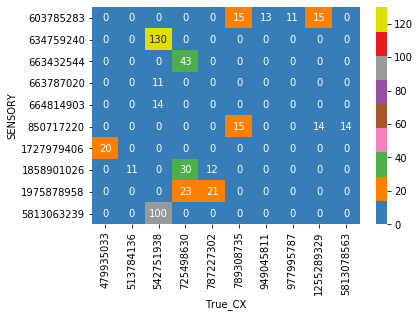

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# color blind friendly colormap (not a gradient)
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
# by body id
heat = sns.heatmap(df_direct_heat, annot = True, fmt='d', cmap = CB_color_cycle) #cmap param allows you to change color palette/gradient
plt.show()

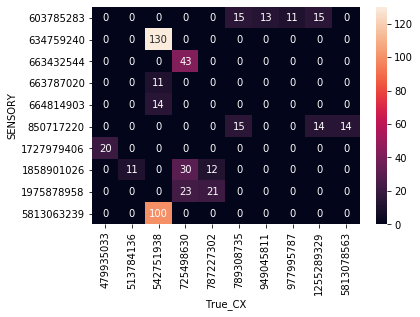

In [42]:
# no colorblind palette
heat = sns.heatmap(df_direct_heat, annot = True, fmt='d')
plt.show()

#### Sub-Section 3.2.2 Query by Type or Read in <a name = 'heat2'></a>

In [25]:
def create_query_dataframe_type():
    query=fetch_custom("""\
    WITH """ + str(body_list) + """ AS TARGETS
    MATCH (a:Neuron)-[c:ConnectsTo]->(b:Neuron)
    WHERE a.bodyId IN TARGETS AND b.`CX` AND c.weight >= 10
    RETURN a.type AS SENSORY_TYPE, b.type AS CX_Type, SUM(c.weight) AS SUM_WEIGHT
    """) 
    return query

df_direct_type = create_query_dataframe_type()

#### Read in CSV

In [27]:
# by type 
direct_type_csv = pd.read_csv(r"C:\Users\17039\Documents\GitHub\CAT-Connectome\Lab Projects\Jayaraman\python\Output files for cat-j python\Direct Final Type.csv")

#### 3.2.2.1 Modify dataframe for heatmap <a name = 'mod'></a>
##### Query

In [32]:
# using query DF
direct_query = df_direct_type.reset_index().groupby(['SENSORY_TYPE', 'CX_Type'])['SUM_WEIGHT'].aggregate('first').unstack().fillna(0).astype(int)

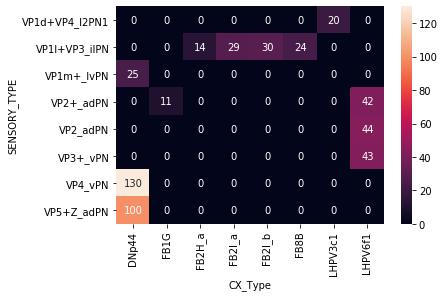

In [35]:
heat = sns.heatmap(direct_query,annot = True, fmt='d')
plt.show()

##### Read In

In [30]:
# CSV read in
direct_csv = direct_type_csv.reset_index().groupby(['Sensory Type', 'CX Type'])['SUM_WEIGHT'].aggregate('first').unstack().fillna(0).astype(int)

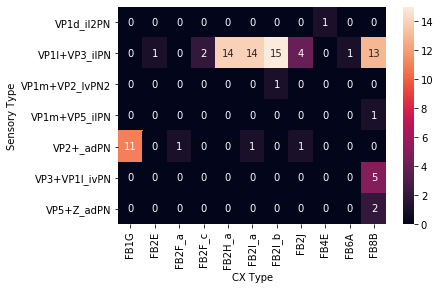

In [40]:
heat = sns.heatmap(direct_csv,annot = True, fmt='d')
plt.show()